In [1]:
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
pd.set_option('display.max_columns', 500)


import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
#read in lipika's cleaned training data
training_data = pd.read_csv("../lipika/cleaned_2013_14", delimiter=',');
print(training_data.shape);

(351757, 50)


In [3]:
display(training_data.head());

,funded_amnt,int_rate,total_pymnt,annual_inc,dti,loan_status,revol_util,term,term_adj,zip_code,emp_length_1 year,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,amnt,paid
0,0.276471,0.0699,6611.69,0.007336,0.373093,Charged Off,0.316,3.0,3.000000,937xx,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10400.0,1
1,0.411765,0.1239,17392.37,0.010004,0.300825,Fully Paid,0.290,5.0,1.500000,235xx,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15000.0,0
2,0.195588,0.1366,2281.98,0.006269,0.870468,Charged Off,0.919,3.0,3.000000,850xx,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7650.0,1
3,0.252941,0.1366,9973.43,0.008804,0.645411,Fully Paid,0.594,3.0,0.333333,077xx,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9600.0,0
4,0.600735,0.1559,25512.20,0.008110,0.462366,Fully Paid,0.762,5.0,1.416667,658xx,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21425.0,0


## Plot distribution of loan amounts for Paid and Defaulted loans

In [6]:
training_data.funded_amnt.max()

1.0000000000000002

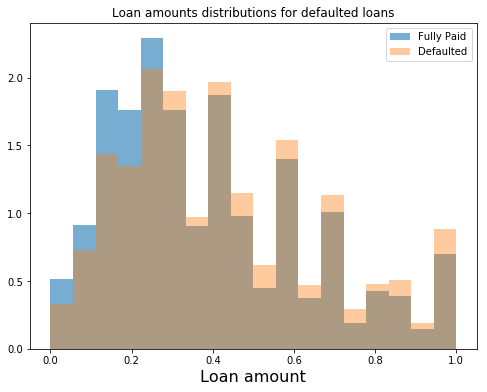

In [5]:
fig = plt.figure(figsize=(8,6));
ax = plt.subplot(1,1,1);
f_size=16;

ax.set_xlabel('Loan amount', fontsize= f_size);
ax.set_title('Loan amounts distributions for defaulted loans')

ax.hist(training_data.loc[training_data.paid == 0, "funded_amnt"], bins=18, density=True, label='Fully Paid', alpha=0.6);
ax.hist(training_data.loc[training_data.paid == 1, "funded_amnt"], bins=18, density=True, label='Defaulted', alpha=0.4);


ax.legend(loc='best');

plt.show()

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


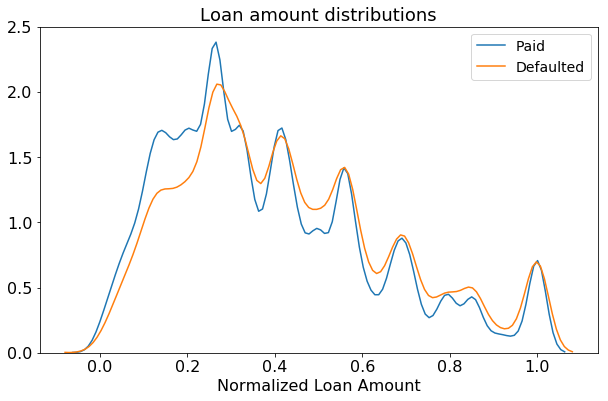

In [29]:
fig = plt.figure(figsize=(10,6));
ax = plt.subplot(1,1,1);
fontsize= 16;

ax.tick_params(labelsize=fontsize);
ax.set_xlabel(xlabel="Normalized Loan Amount", fontsize=fontsize);
ax.set_title(label="Loan amount distributions", fontsize=18)
#plot the funded amount for loans that were paid back and those that defaulted
sns.kdeplot(data = training_data.loc[training_data.paid == 0, "funded_amnt"], label = "Paid", ax = ax);
sns.kdeplot(data = training_data.loc[training_data.paid == 1, "funded_amnt"], label = "Defaulted", ax = ax);
ax.legend(fontsize=14);

plt.show()

There is a slight left shift in the distribution for loans that were paid back, which could possibly be exploited for higher rates of return.

In [22]:
training_data_gb = training_data.groupby(by='paid').agg({
    'int_rate':'mean'
})
training_data_gb

,int_rate
paid,
0,0.134458
1,0.163700


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


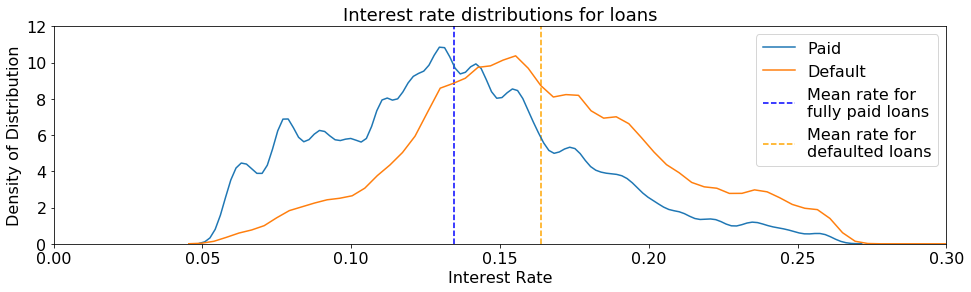

In [27]:
fig = plt.figure(figsize=(16,4));
ax = plt.subplot(1,1,1);
f_size=16;

ax.set_xlabel('Interest Rate', fontsize= f_size);
ax.set_ylabel('Density of Distribution', fontsize= f_size);
ax.set_title('Interest rate distributions for loans', fontsize=18)
ax.set_xlim(left=0, right=0.3);
ax.set_ylim(bottom=0, top=12);
ax.tick_params(labelsize=f_size);



sns.kdeplot(training_data.loc[training_data.paid == 0, 'int_rate'], label='Paid', ax=ax);
ax.vlines(x=training_data_gb.int_rate[0], ymin=0, ymax=12, colors='b', linestyles='dashed', label="Mean rate for \nfully paid loans")

sns.kdeplot(training_data.loc[training_data.paid == 1, 'int_rate'], label='Default', ax=ax);
ax.vlines(x=training_data_gb.int_rate[1], ymin=0, ymax=12, colors='orange', linestyles='dashed', label="Mean rate for \ndefaulted loans")

ax.legend(loc='best', fontsize=f_size);

# plt.show()
# plt.savefig('Interest_rate_distrb_for_loans.png', bbox_inches='tight');

Interest rate could also be a good predictor of defaulted loans since the distribution of interest rates for paid back loans is shifted to the left compared to the distribution of interest rates for defaulted loans.